In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## IMPORTING PACKAGES
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#torch.set_default_tensor_type(torch.FloatTensor)

print(device)

cuda


In [4]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.autolayout"] = True

In [5]:
from Setting_Variables import get_params

Dynamical_System = 'LI'

params = get_params(Dynamical_System)
params['Dynamical_System'] = Dynamical_System
print(params)

{'sigma_real': 0.0, 'N_aux': 2, 'NX_dim': 1, 'N_noise': 2, 'N_delays': 0, 'dt': 0.1, 'Amplitude': 2.0, 'X0': tensor([0.]), 'RK': 2, 'N_S': 1, 'Dynamical_System': 'LI'}


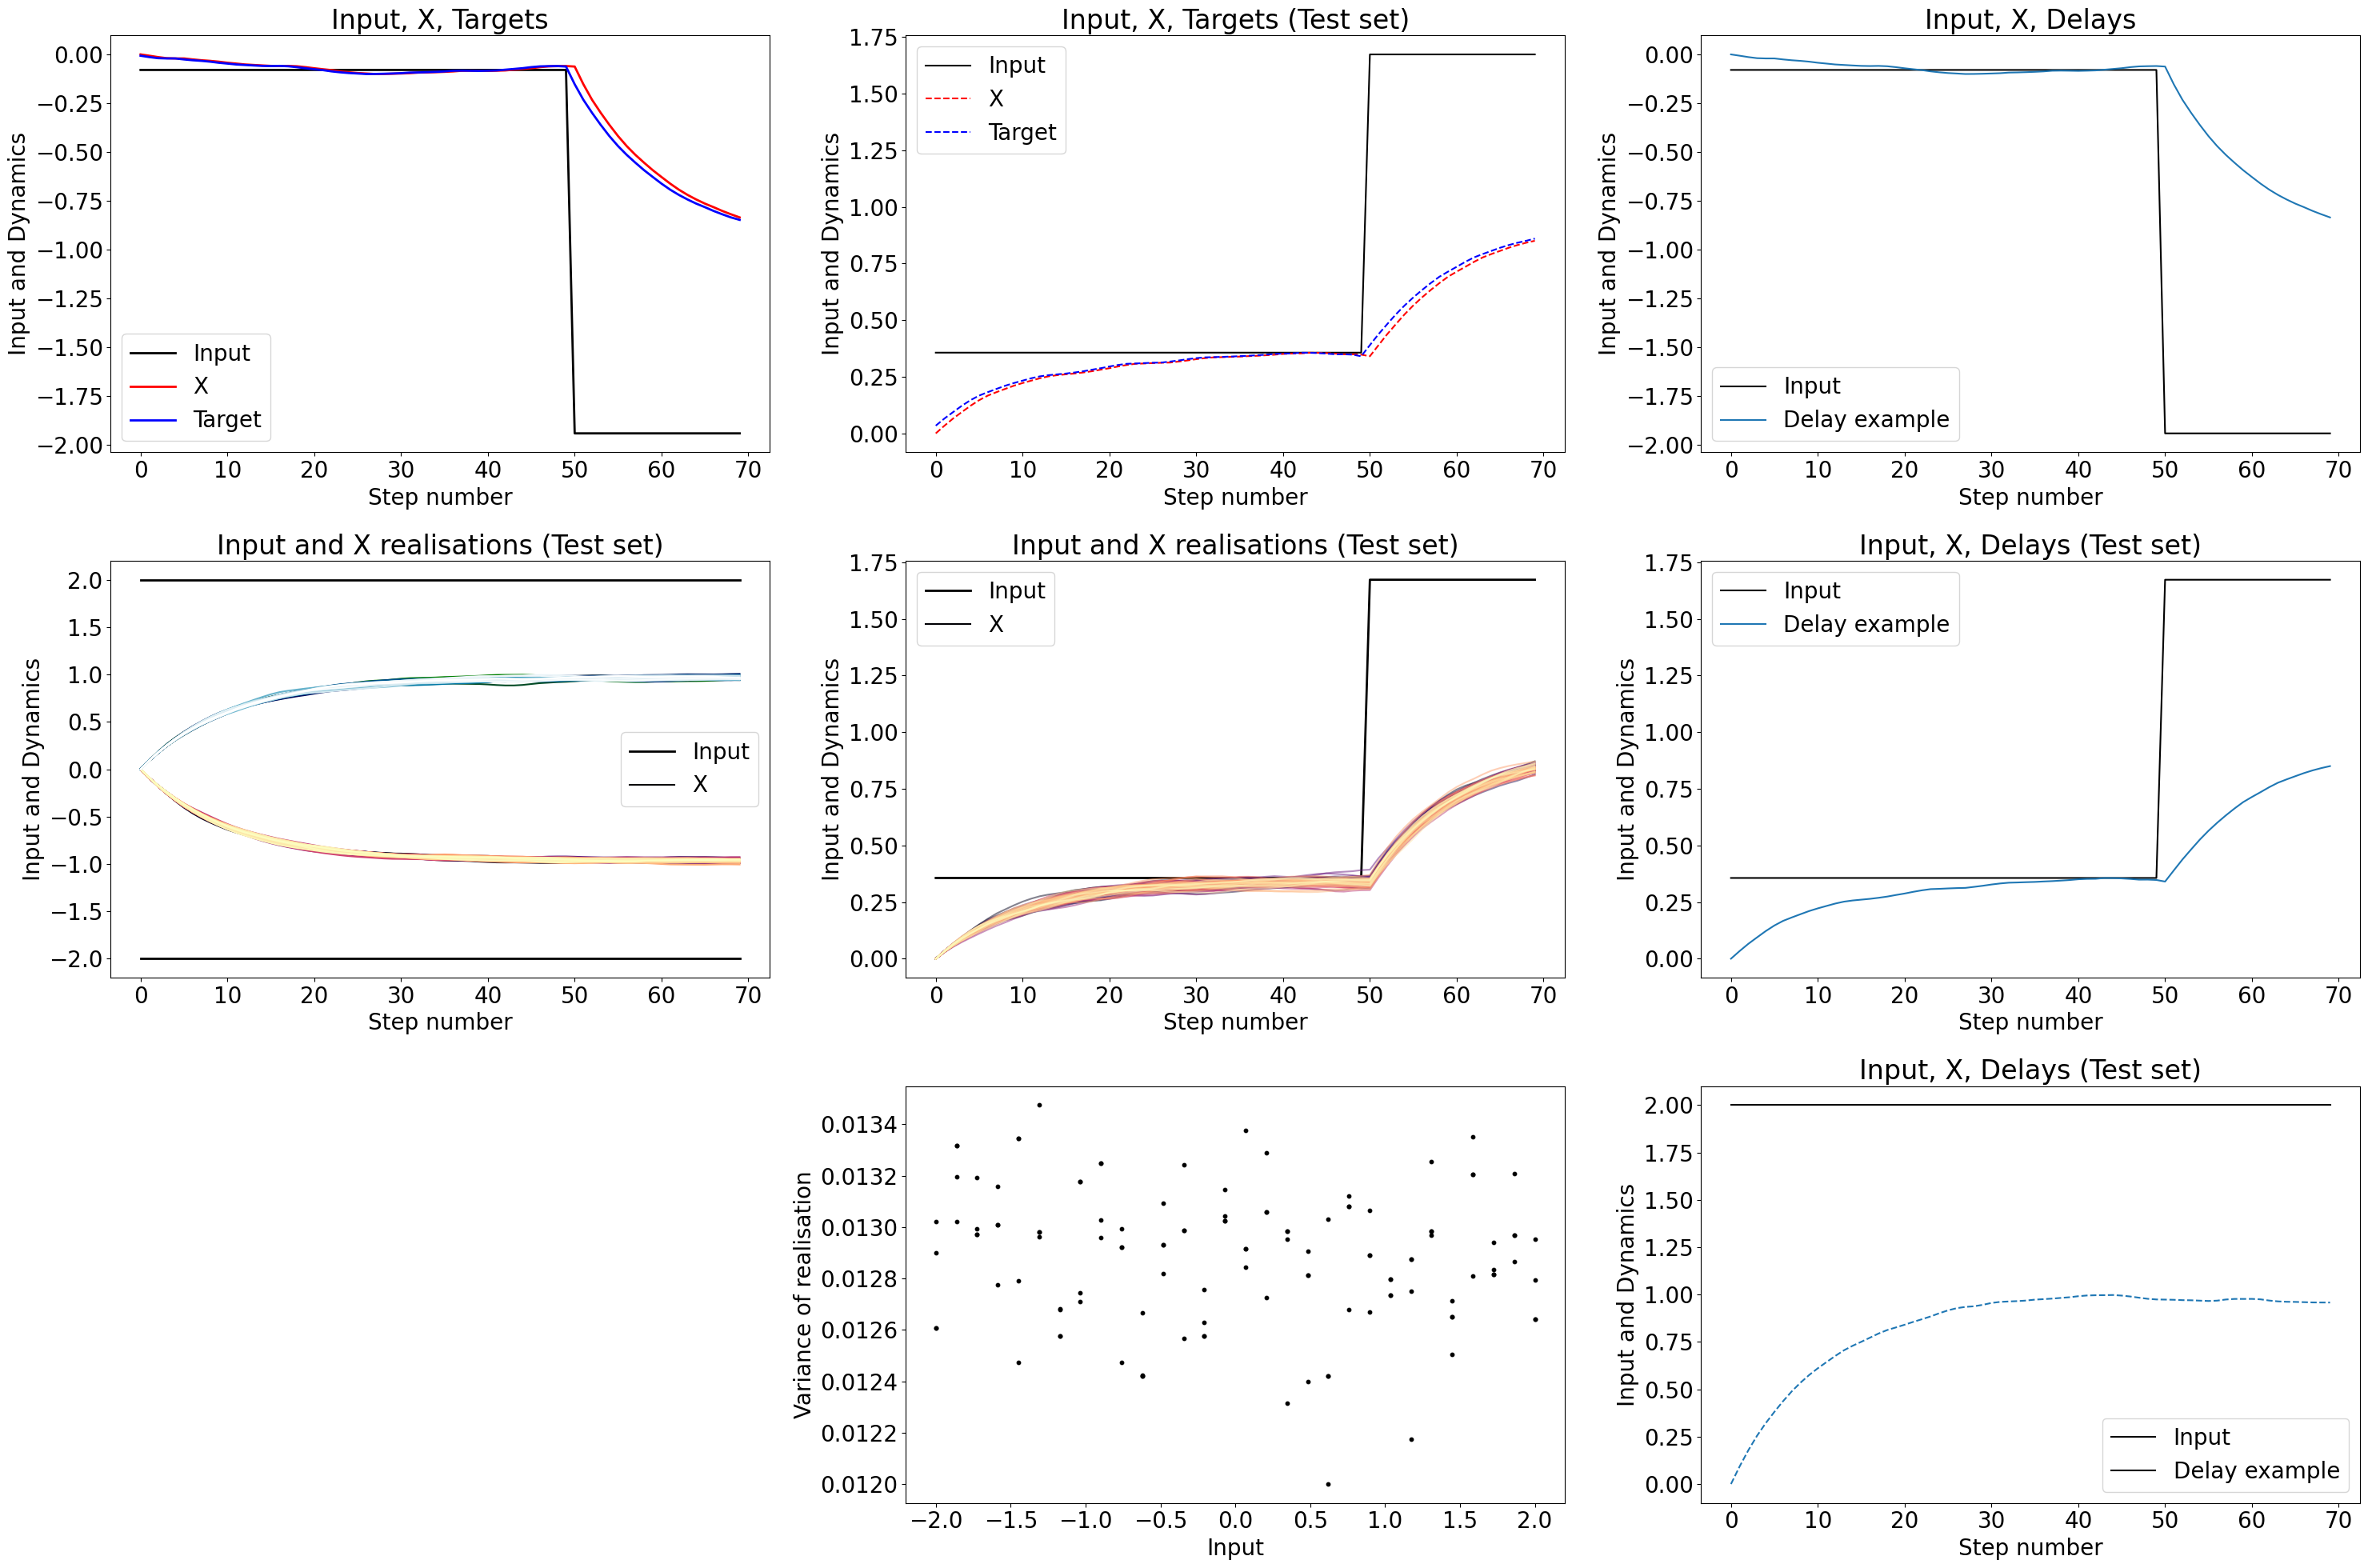

In [ ]:
from generate_data import Generate_Data

if Dynamical_System=='LI':

    from LI_Definition import Leaky_Integrator

    ## The following parameters define the shape of the square waves-like input to the dynamical system.
    ## This defined the number of input changes per trajectory. T_steps[0] implies a generation of N trajectories
    ## where the input changes T_steps[0] times
    T_steps=[50,5]

    ## The number of steps over which an input value is repeated.
    Repeat=[5,50]

    real_system = Leaky_Integrator()


if Dynamical_System=='DO':

    from DO_Definition import Duffing_Oscillator

    ## Similar to the above
    T_steps=[20,6]
    Repeat=[15,50]

    real_system = Duffing_Oscillator()


if Dynamical_System=='LI' or Dynamical_System=='DO':

    ## binary mask that wdefines where the noise, in the analytical system, is present
    sigmas=torch.ones([params['NX_dim']+params['N_aux'], params['N_noise'] ], device=device)

    if params['N_aux']>0:
        sigmas[0,:]=0

    ## Definition of the object to generate the data for the analytical models
    GD = Generate_Data(
            real_system.model,
            real_system.Noise_SigXI,
            real_system.Preprocess_S,
                    sigmas,
                    device,
                    params['NX_dim'],
                    params['N_delays'],
                    params['dt'],
                    params['N_S'],
                    params['N_aux'])

    ## Dataset construction
    S, Input, Target, S_te, Input_te, Target_te, S_val, Input_val, Target_val, S_te_ordered, Input_te_ordered,\
    Target_te_ordered = GD.Generate_DataSet(params['X0'], params['Amplitude'], T_steps, Repeat)


    ## length of the segments over which the system performs backpropagation
    T_horizon=3 # Original value : 10

    ## Auxiliary variables
    N_int_aux=10
    N_ext_aux=0
    N_aux_model=N_int_aux+N_ext_aux
    params['N_aux_model'] = N_aux_model

    ## binary mask for the model
    N_noise=params['N_noise']
    sigmas_model=torch.zeros([N_aux_model+params['NX_dim']*(params['N_delays']+1), params['N_noise']], device=device)

    ## Learning rates, batch size, magnitude of the penalty term for gradient clipping
    etas=[0.0001,0.00005,0.0005]
    batch_size=100
    lamda=10

    t0=torch.tensor(0.)

    F_Ns=torch.tensor([Target.size()[1]+1,200,Target.size()[1]])

    G_out=sigmas_model.size()[0]
    G_Ns=torch.tensor([Target.size()[1]+1, 500, 500, G_out*N_noise])

    D_Ns=torch.tensor([T_horizon*params['NX_dim']+T_horizon*params['N_S'],500,500,1])

    N_datasets=1


    ## We embed the data into lists because of the possibility of having multiple datasets, with different temporal lengths
    ## For instance, for the nanorings, we have two datasets.
    Input=[Input]
    Input_te=[Input_te]
    Input_val=[Input_val]

    Target=[Target]
    Target_te=[Target_te]
    Target_val=[Target_val]

    Train_F2=False ## The deterministic component is only trained in the first phase
    Train_Type=[0,1,1]


In [12]:
# INITIALISATION OF THE NEURAL SDE/ODE
from neural_SDE import NeuralSDE_BPTT

Manual_load_of_weights=False ## This can be used to load manually weights for the determinstic component (if one has
## a previous neural ODE model). You will need a model to set it to True...

if Manual_load_of_weights:

    N_SDE=torch.load("Parameters_SDE_2_Rings_NDelaysCopy_4T_horizon_50.pt")

    load_weightsF=[[N_SDE.F.F[0].weight.T,N_SDE.F.F[2].weight.T,N_SDE.F.F[4].weight.T,N_SDE.F.F[6].weight.T],\
                [N_SDE.F.F[0].bias,N_SDE.F.F[2].bias,N_SDE.F.F[4].bias,N_SDE.F.F[6].bias]]


    load_weightsD=[[N_SDE.D.D[0].weight.T,N_SDE.D.D[2].weight.T,N_SDE.D.out.weight.T],\
                [N_SDE.D.D[0].bias,N_SDE.D.D[2].bias,N_SDE.D.out.bias]]

else:

    load_weightsF=[]

    load_weightsD=[]


N_SDE=NeuralSDE_BPTT(F_Ns,G_Ns,D_Ns,N_int_aux,N_ext_aux,sigmas_model,\
                     params['NX_dim'], params['N_S'], device,
                     load_weightsF=load_weightsF,load_weightsD=load_weightsD)

N_SDE.Initialise_Hyperparameters(params['dt'], etas, lamda,
                                 sigmas_model,
                                 Train_Type,
                                 params['RK'])

In [13]:
## Training iterations

N_ST1 = 2000     ## NUMBER OF ITERATIONS IN THE FIRST PHASE, TRANING THE DETERMINSITIC COMPONENT
N_ST  = 2000      ## NUMBER OF ITERATIONS STOCHASTIC TRAINING

D_step = 10

First Phase of Training


 50%|████▉     | 996/2000 [00:20<00:21, 47.69it/s]

cuda:0


 50%|████▉     | 996/2000 [00:30<00:21, 47.69it/s]

New Plot, Old error:  tensor(1) New Error:  tensor(0.0618)


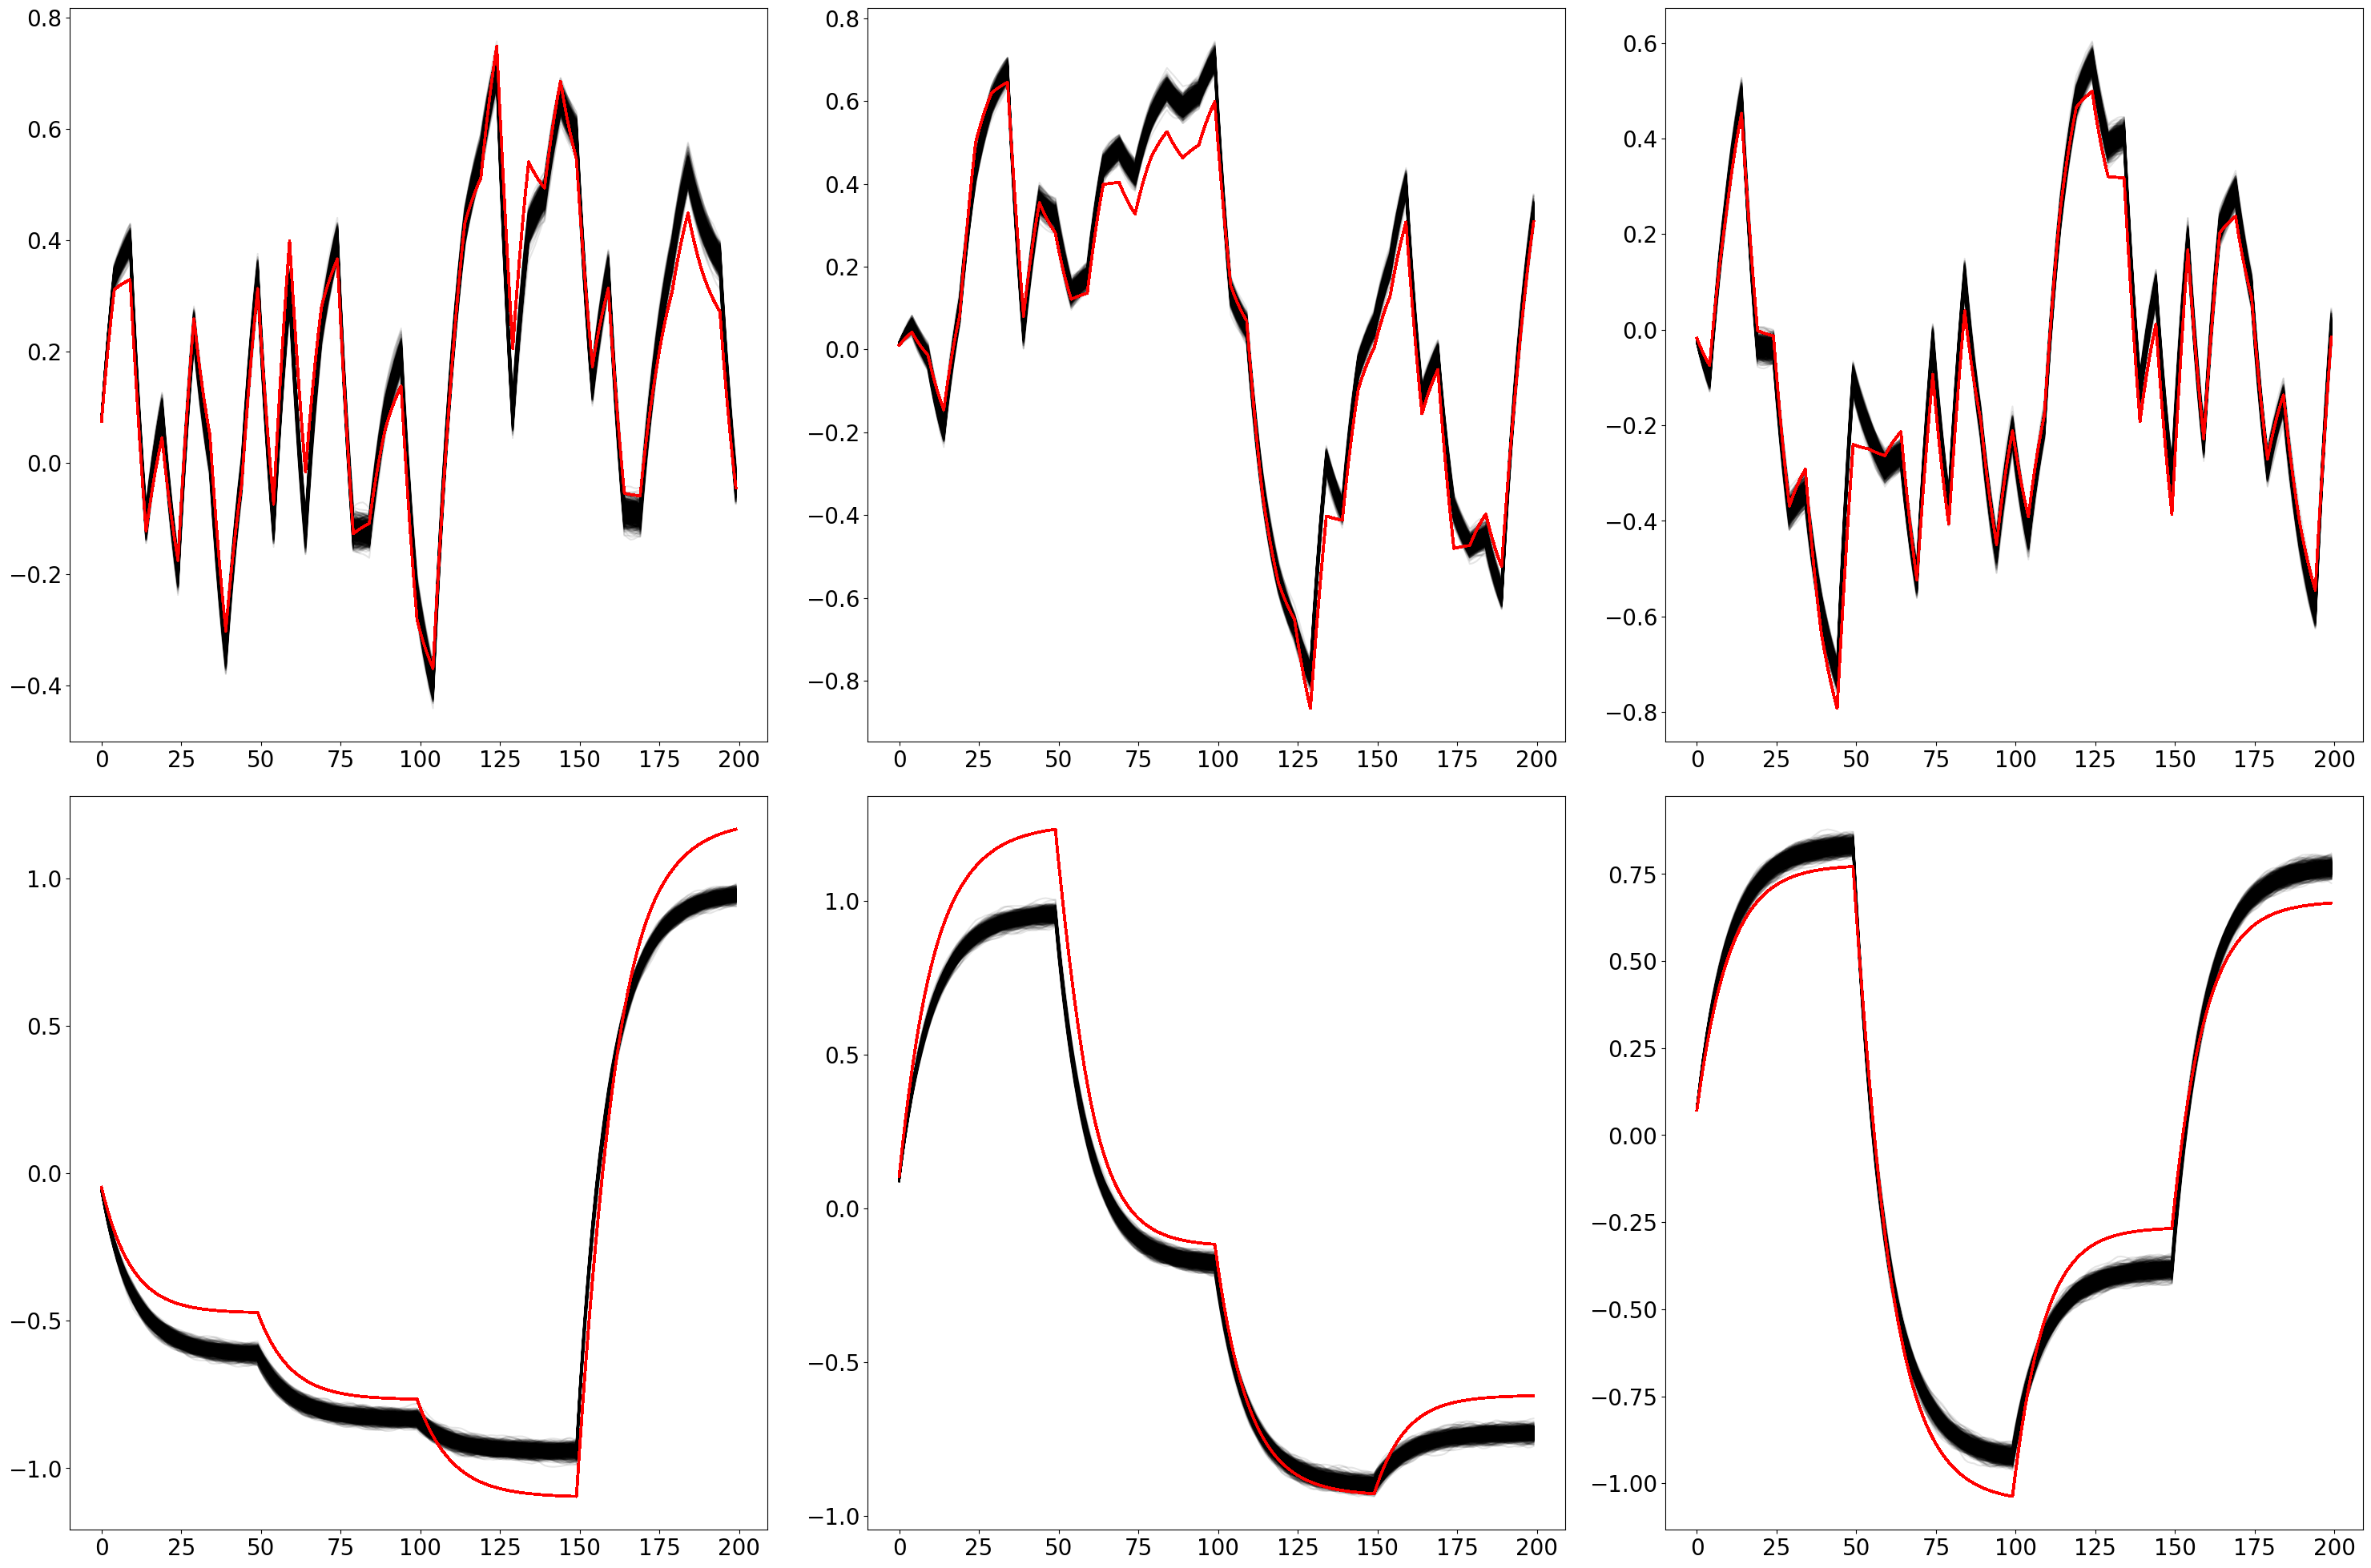

 50%|█████     | 1005/2000 [01:01<29:36,  1.79s/it]

999  Errors on distributions Data: tensor([0.0618, 0.0126, 0.0011]) tensor([0.0615, 0.0126, 0.0011])


100%|█████████▉| 1995/2000 [01:21<00:00, 48.04it/s]

cuda:0


100%|█████████▉| 1995/2000 [01:40<00:00, 48.04it/s]

New Plot, Old error:  tensor(0.0618) New Error:  tensor(0.0433)


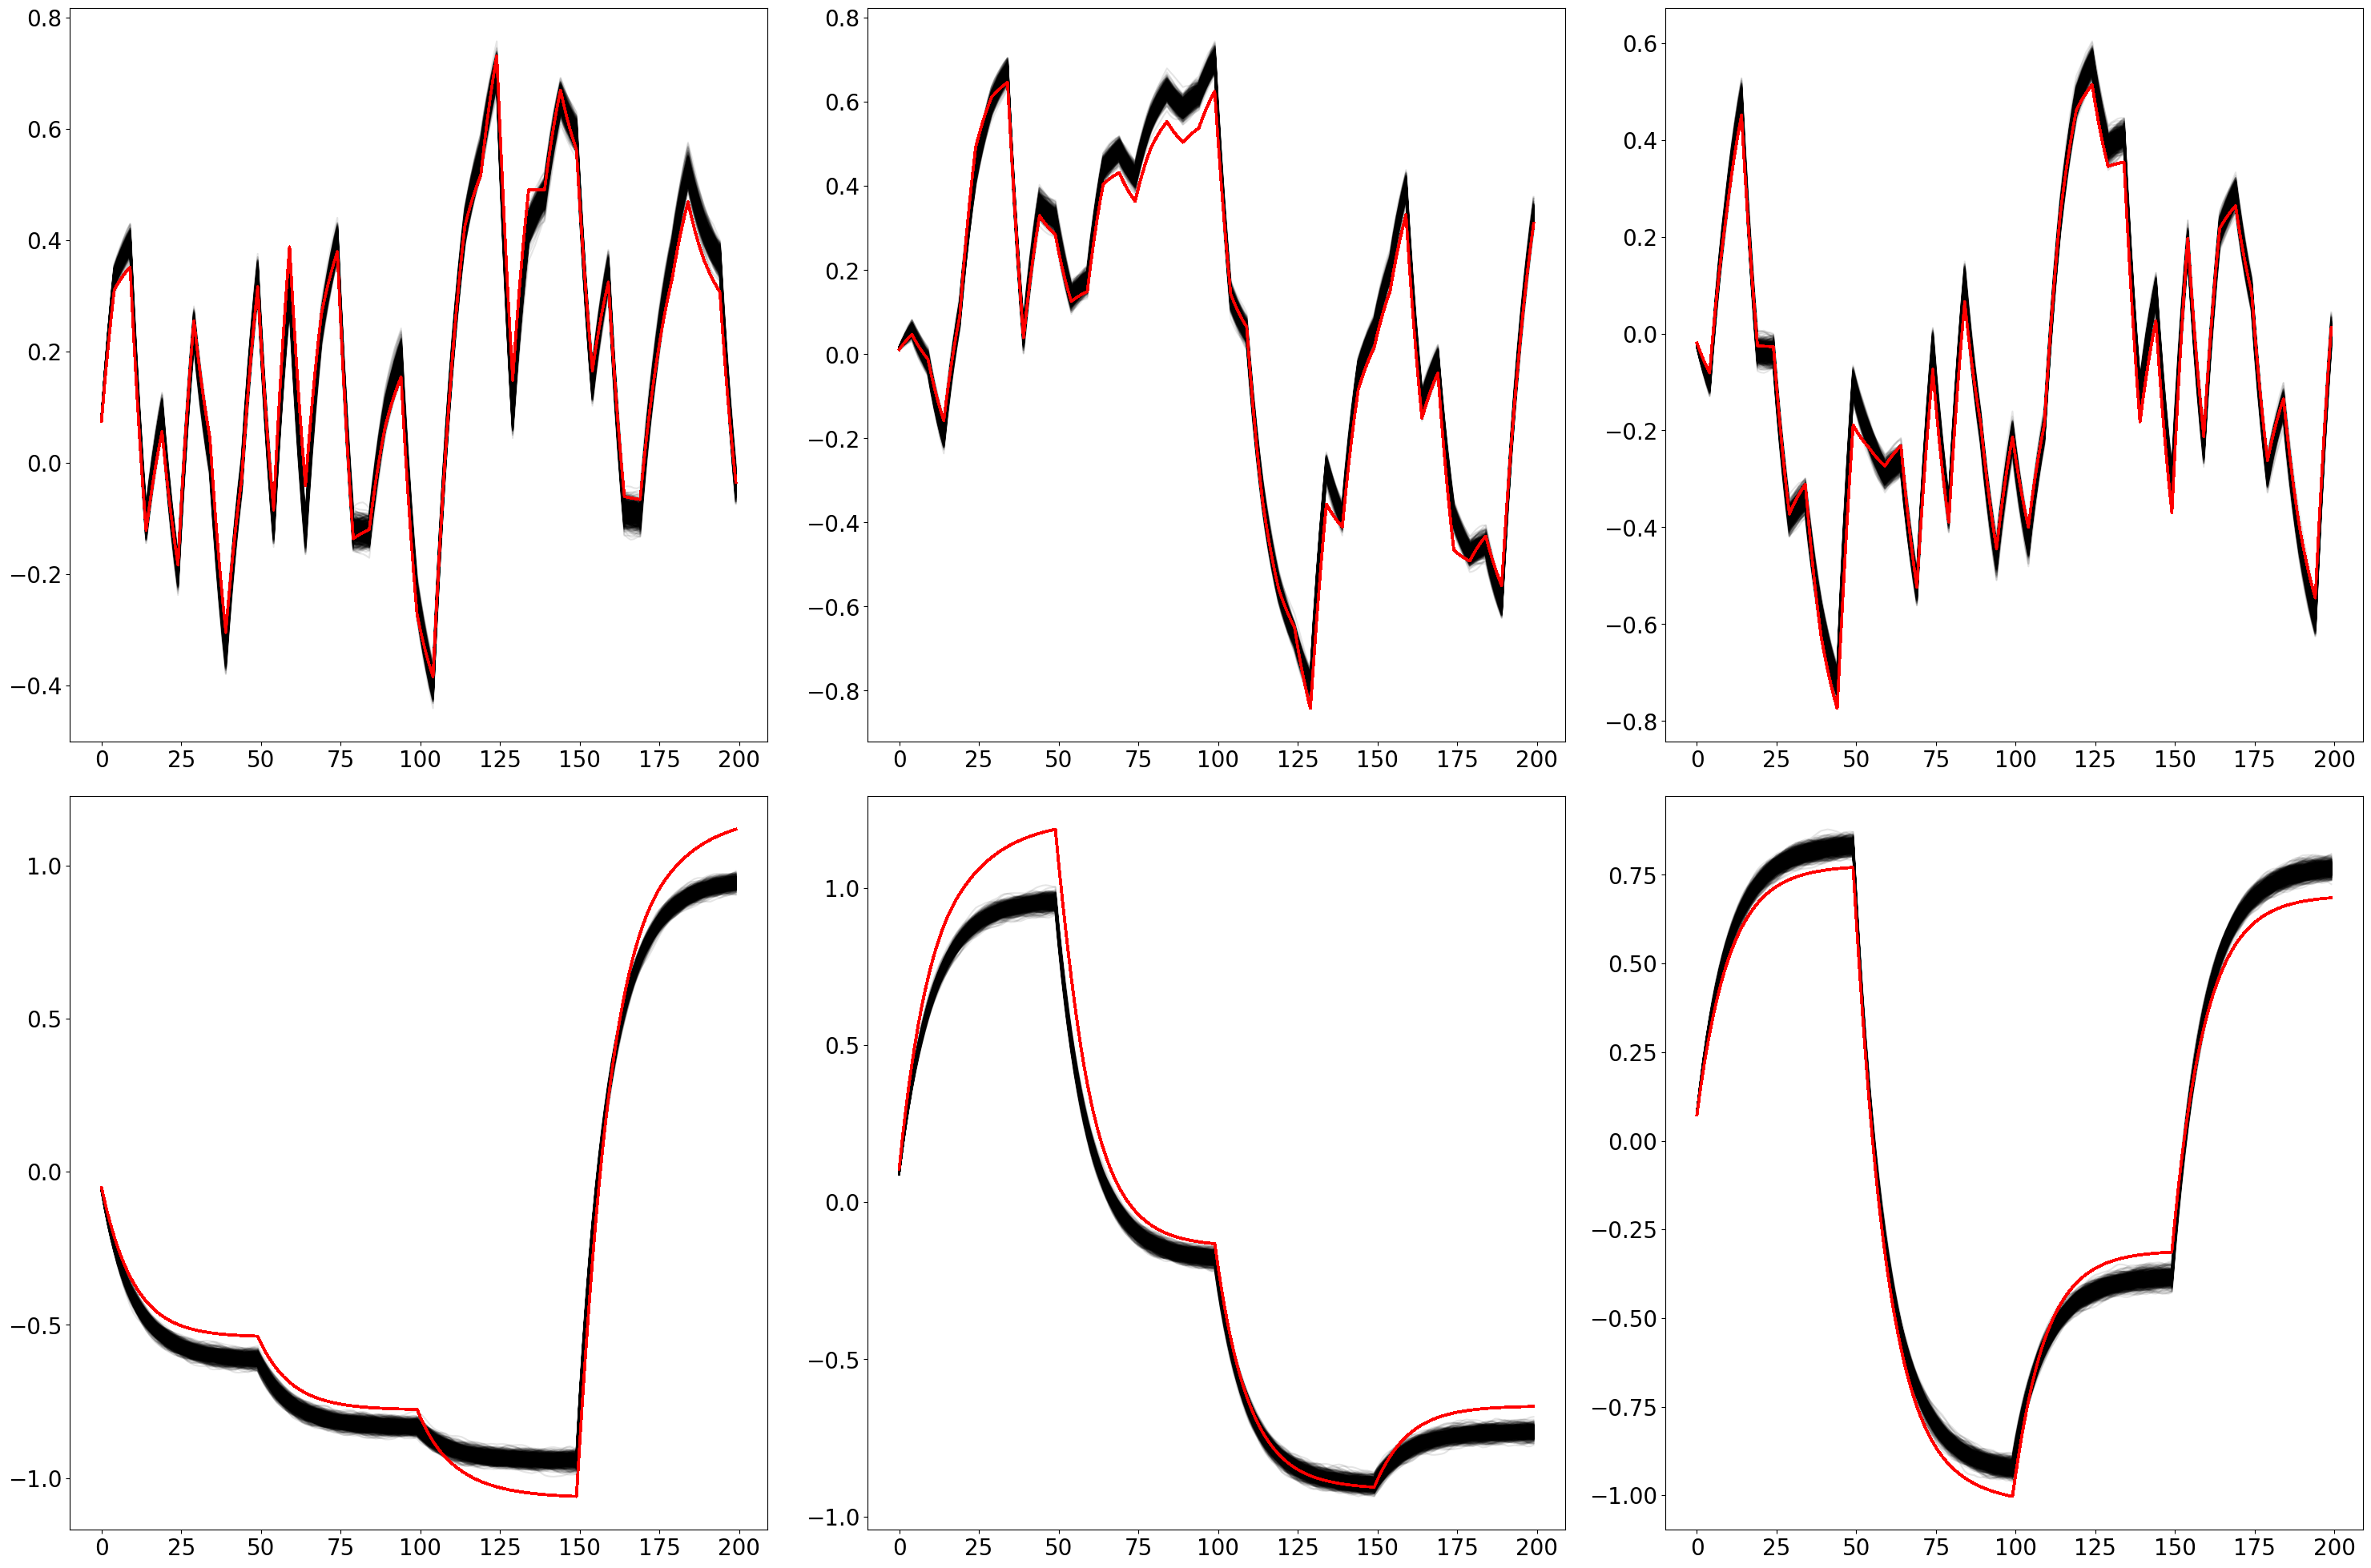

100%|██████████| 2000/2000 [02:02<00:00, 16.30it/s]

1999  Errors on distributions Data: tensor([0.0433, 0.0126, 0.0011]) tensor([0.0433, 0.0126, 0.0011])


In [14]:
from neural_SDE_training import train_NSDE_phase1

Errors_val1, Best_err_av = train_NSDE_phase1(N_SDE, N_ST1, Input, Target, Input_val, Target_val, Input_te, Target_te, T_horizon, params, device, batch_size, t0, print_steps=1000)

Second Phase of Training
Noise Variance Binary Mask: tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')


 25%|██▍       | 499/2000 [01:40<05:02,  4.96it/s]

New Plot, Old error:  tensor(1.) New Error:  tensor(0.0512)


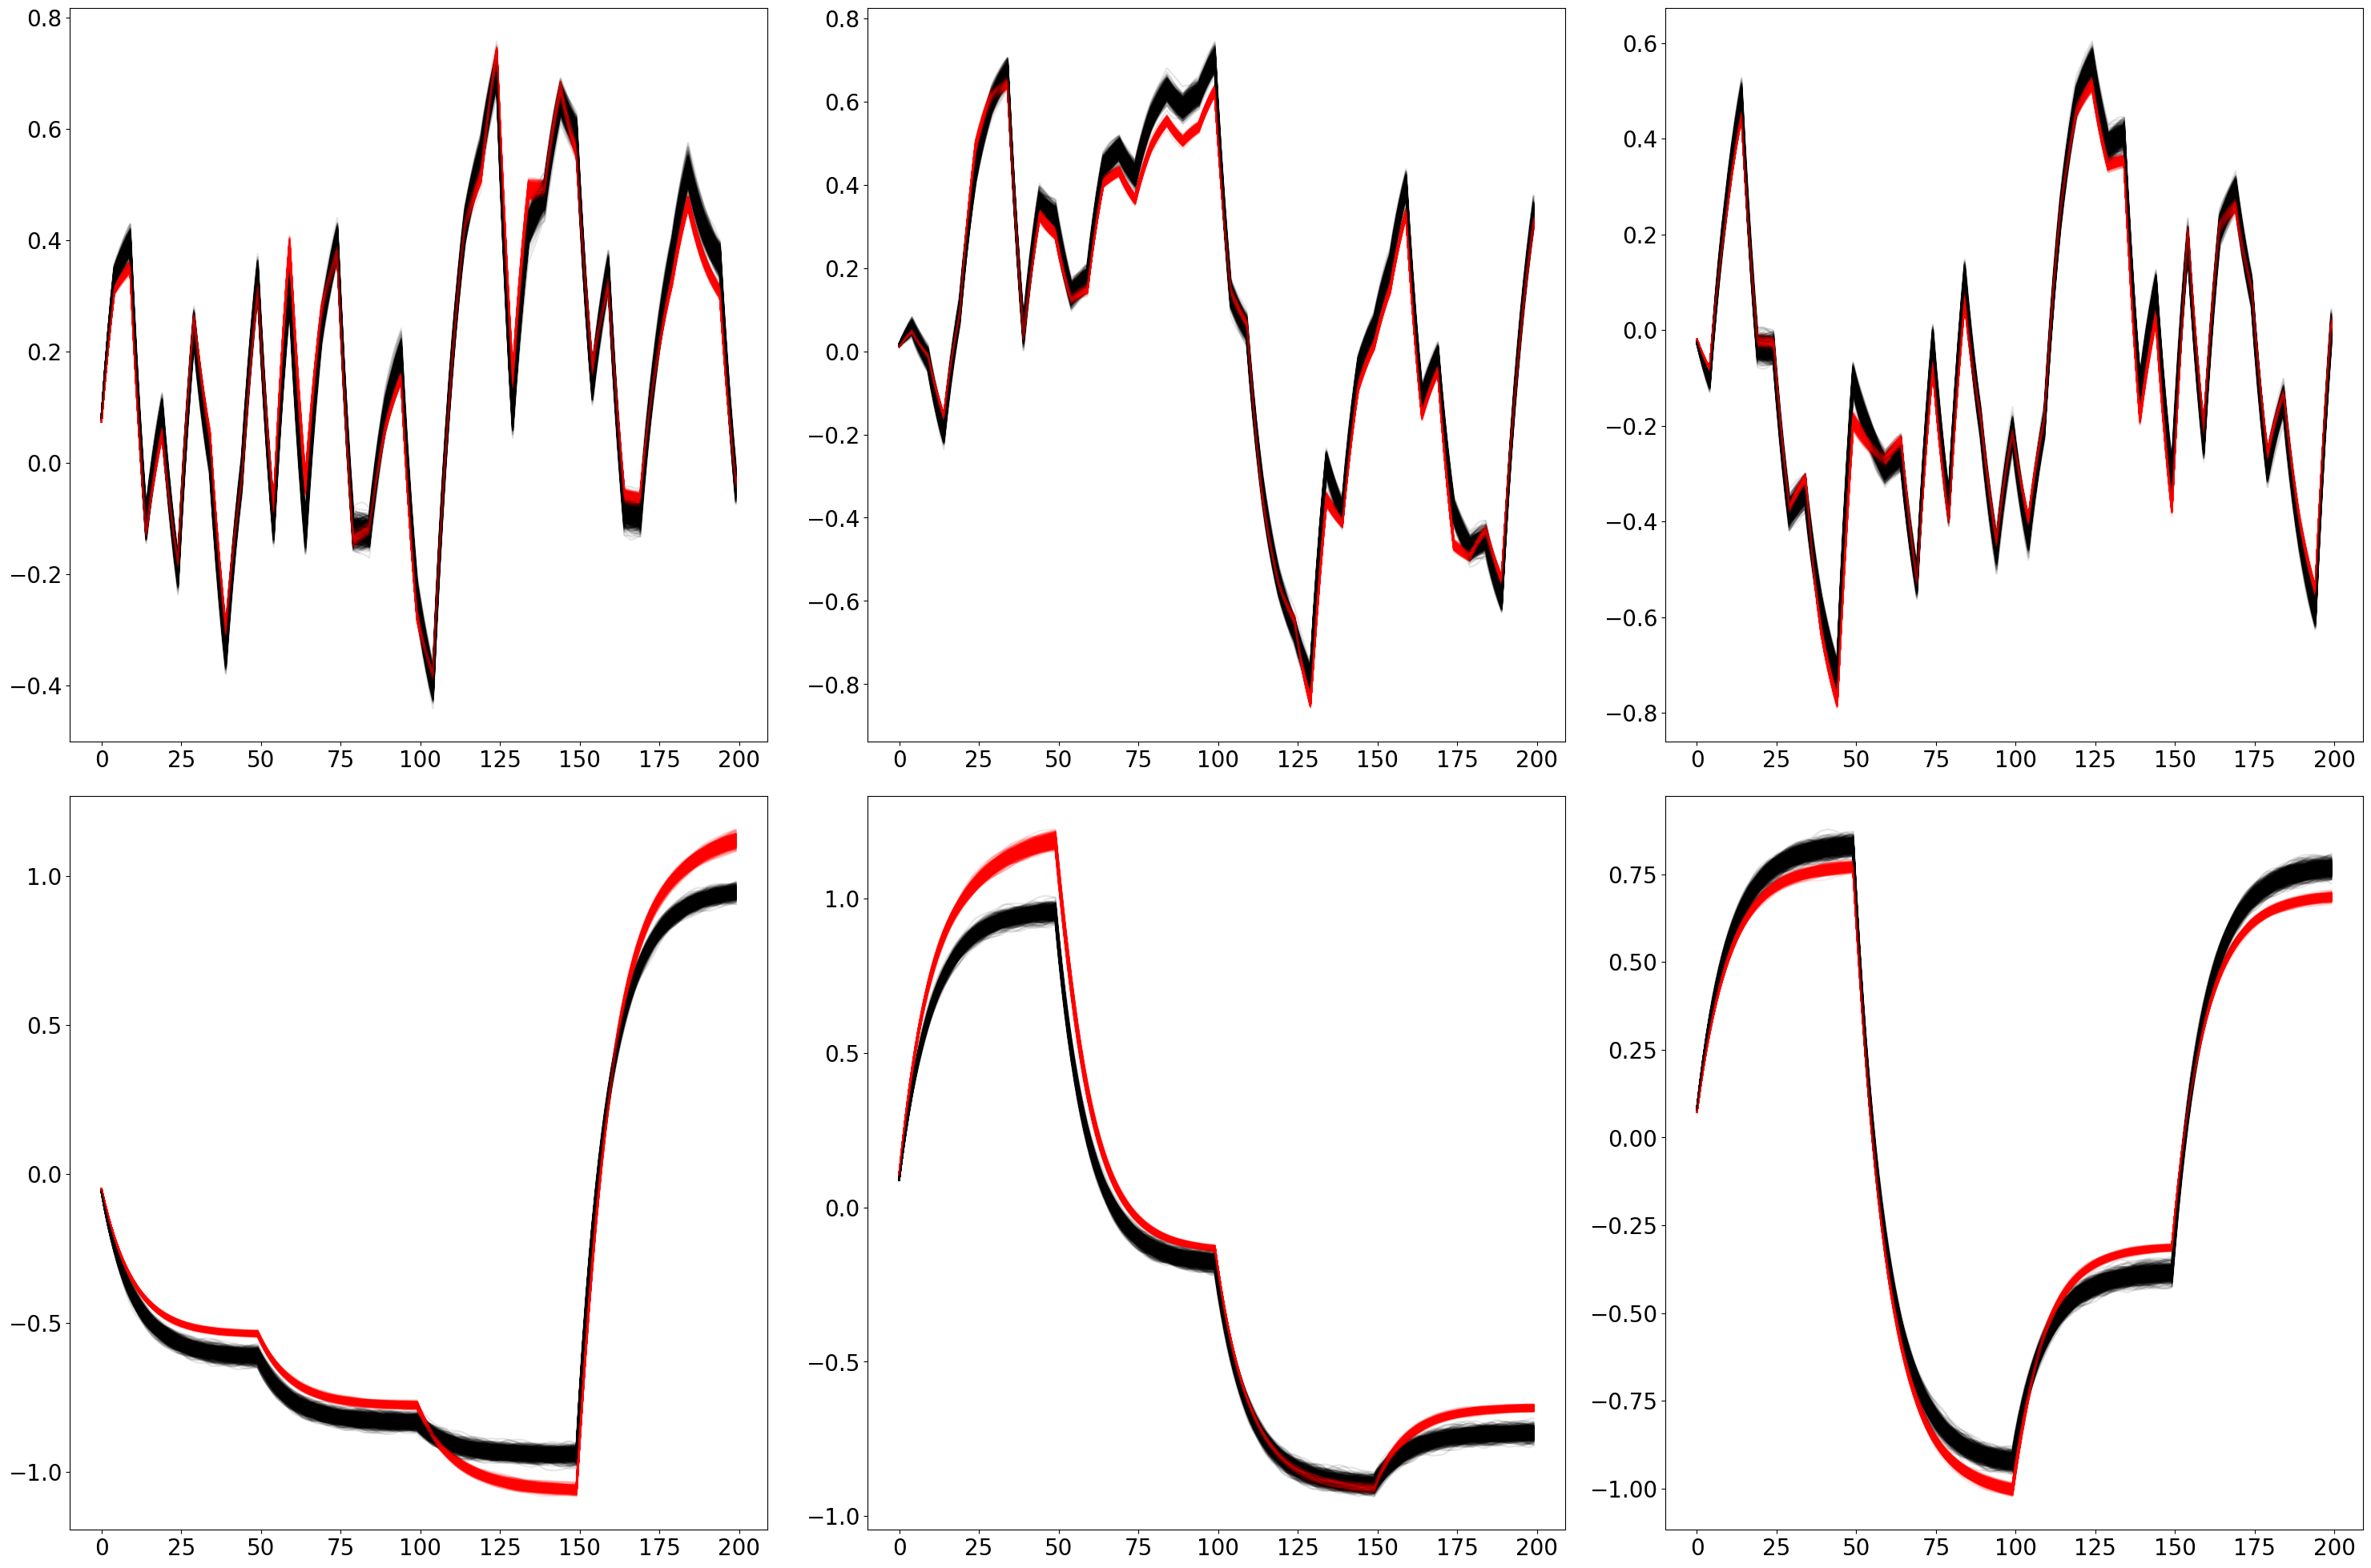

 25%|██▌       | 500/2000 [02:34<6:44:39, 16.19s/it]

499  Errors on distributions Data: tensor([0.0433, 0.0073, 0.0006]) tensor([0.0433, 0.0072, 0.0006])


 50%|████▉     | 999/2000 [04:16<03:24,  4.90it/s]  

New Plot, Old error:  tensor(0.0512) New Error:  tensor(0.0502)


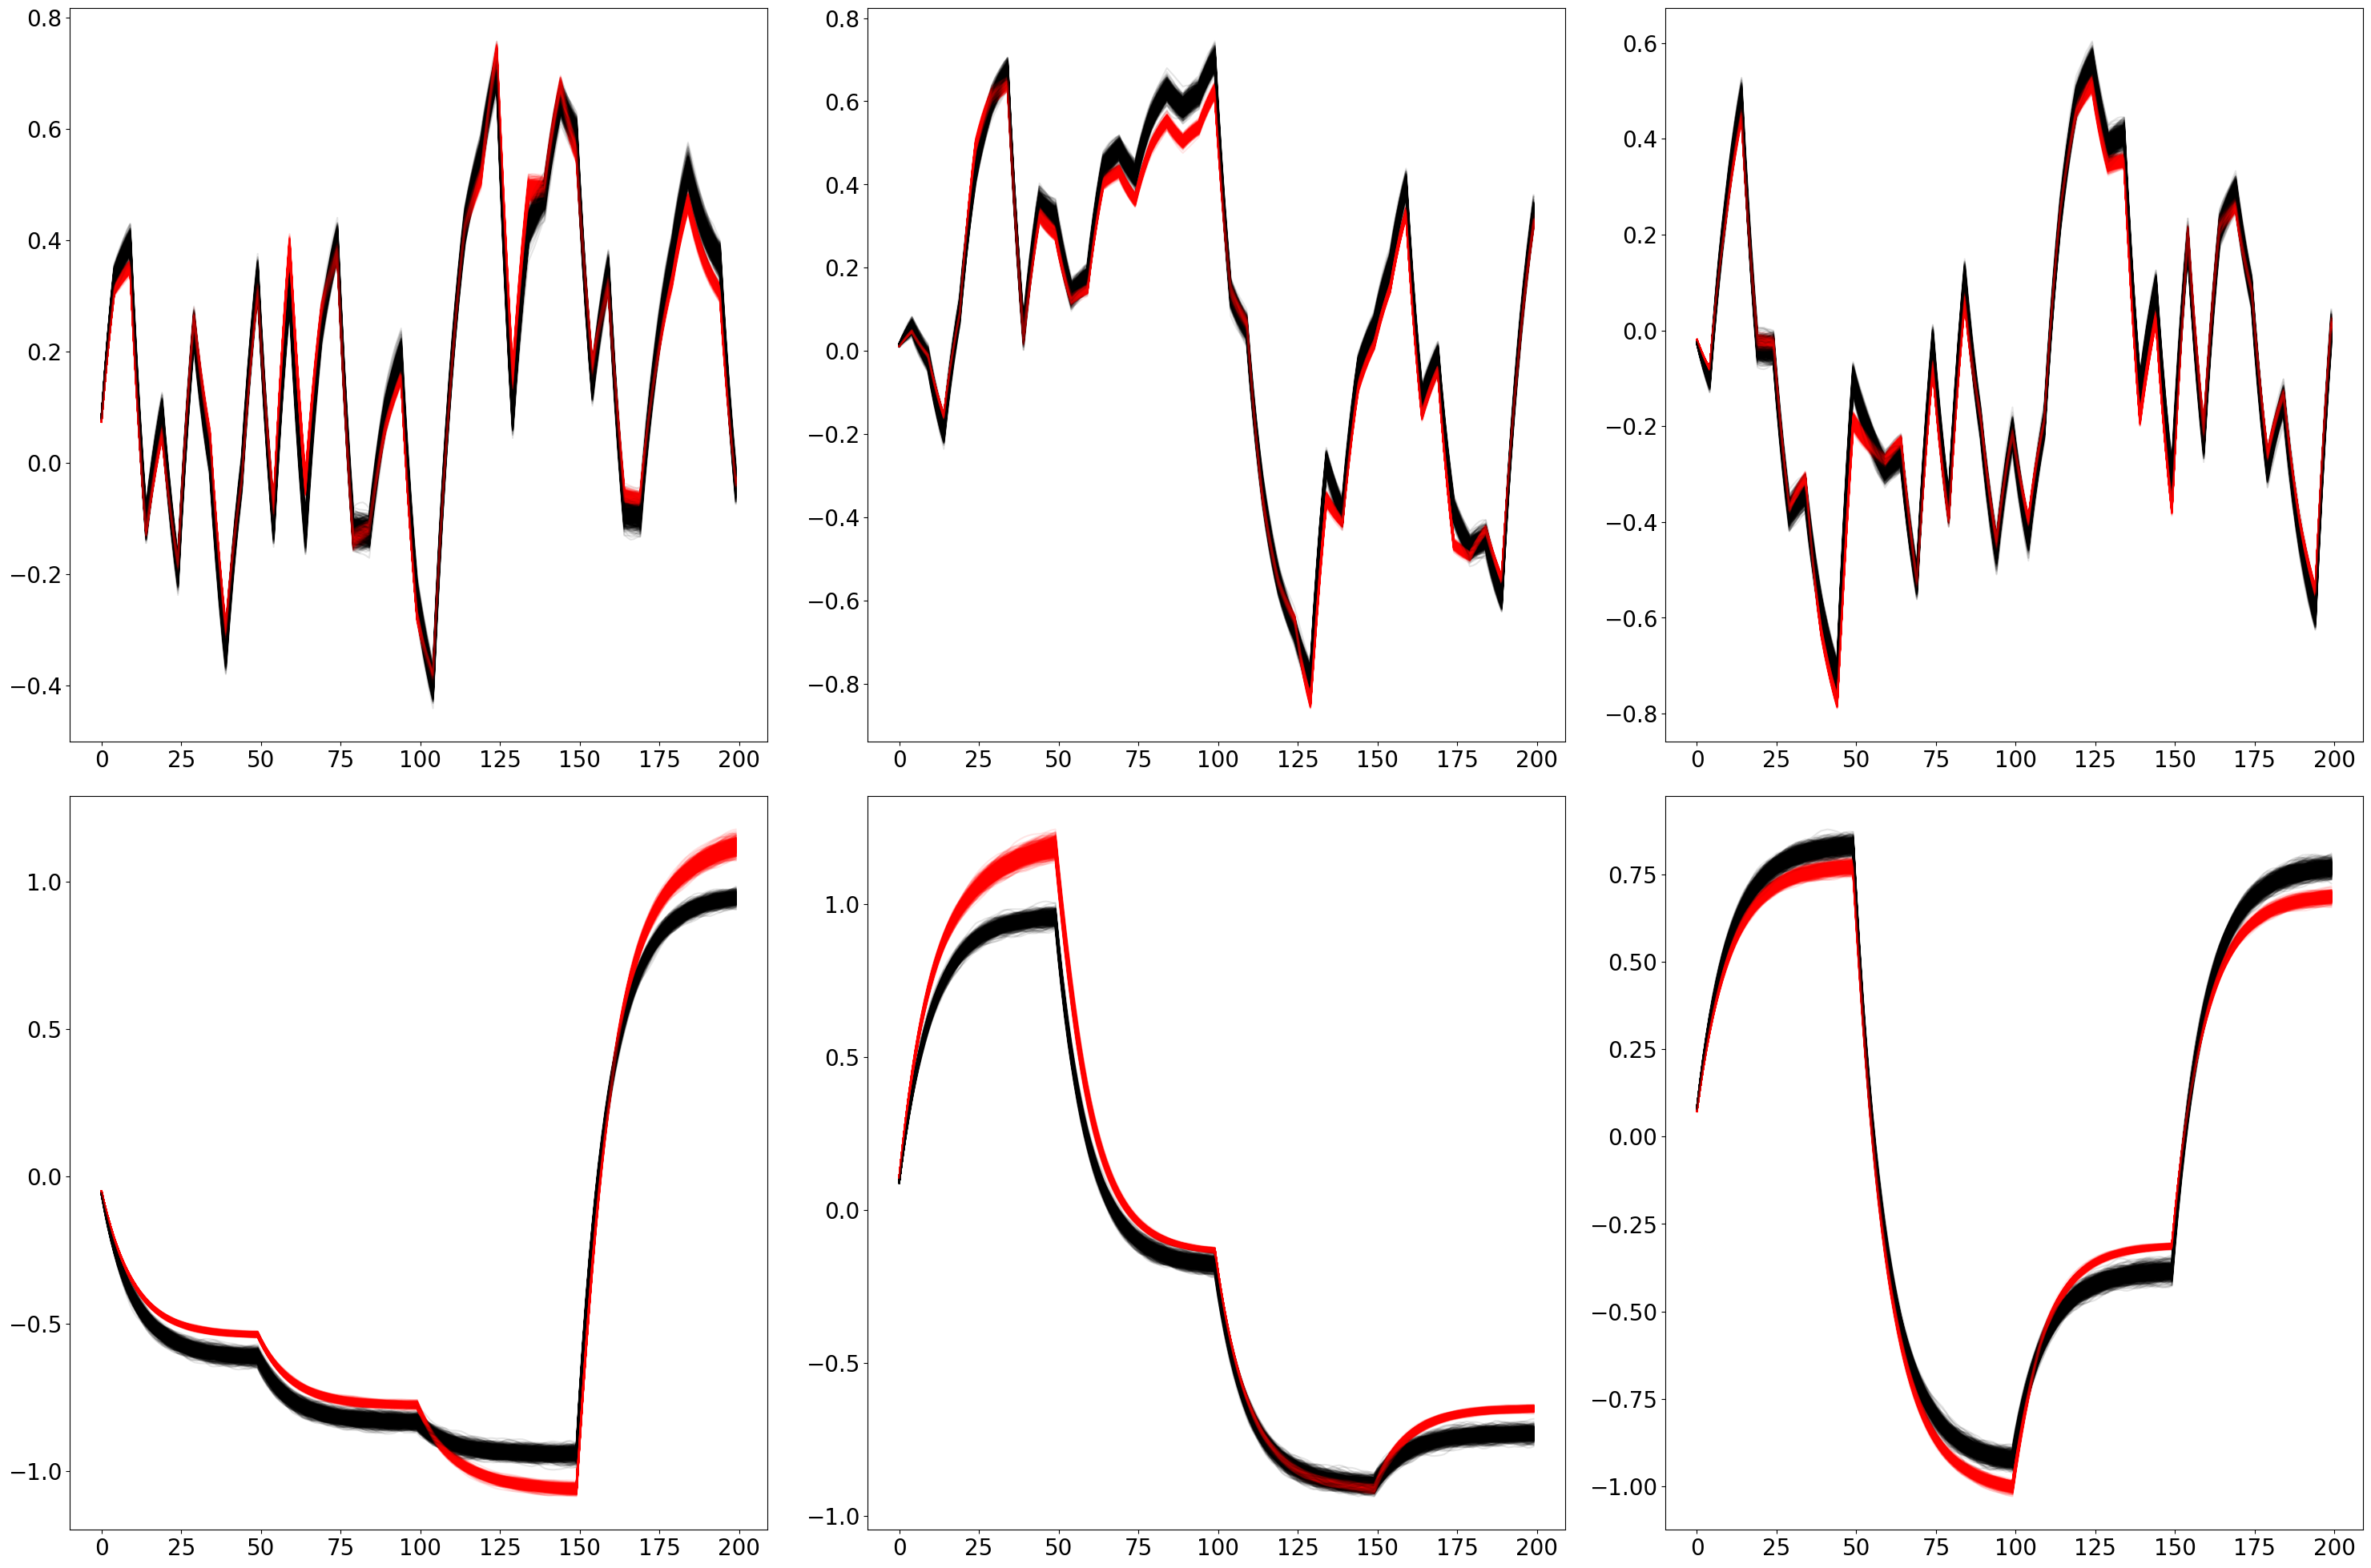

 50%|█████     | 1000/2000 [05:10<4:32:20, 16.34s/it]

999  Errors on distributions Data: tensor([0.0433, 0.0063, 0.0005]) tensor([0.0433, 0.0064, 0.0006])


 75%|███████▍  | 1499/2000 [06:51<01:49,  4.57it/s]  

New Plot, Old error:  tensor(0.0502) New Error:  tensor(0.0479)


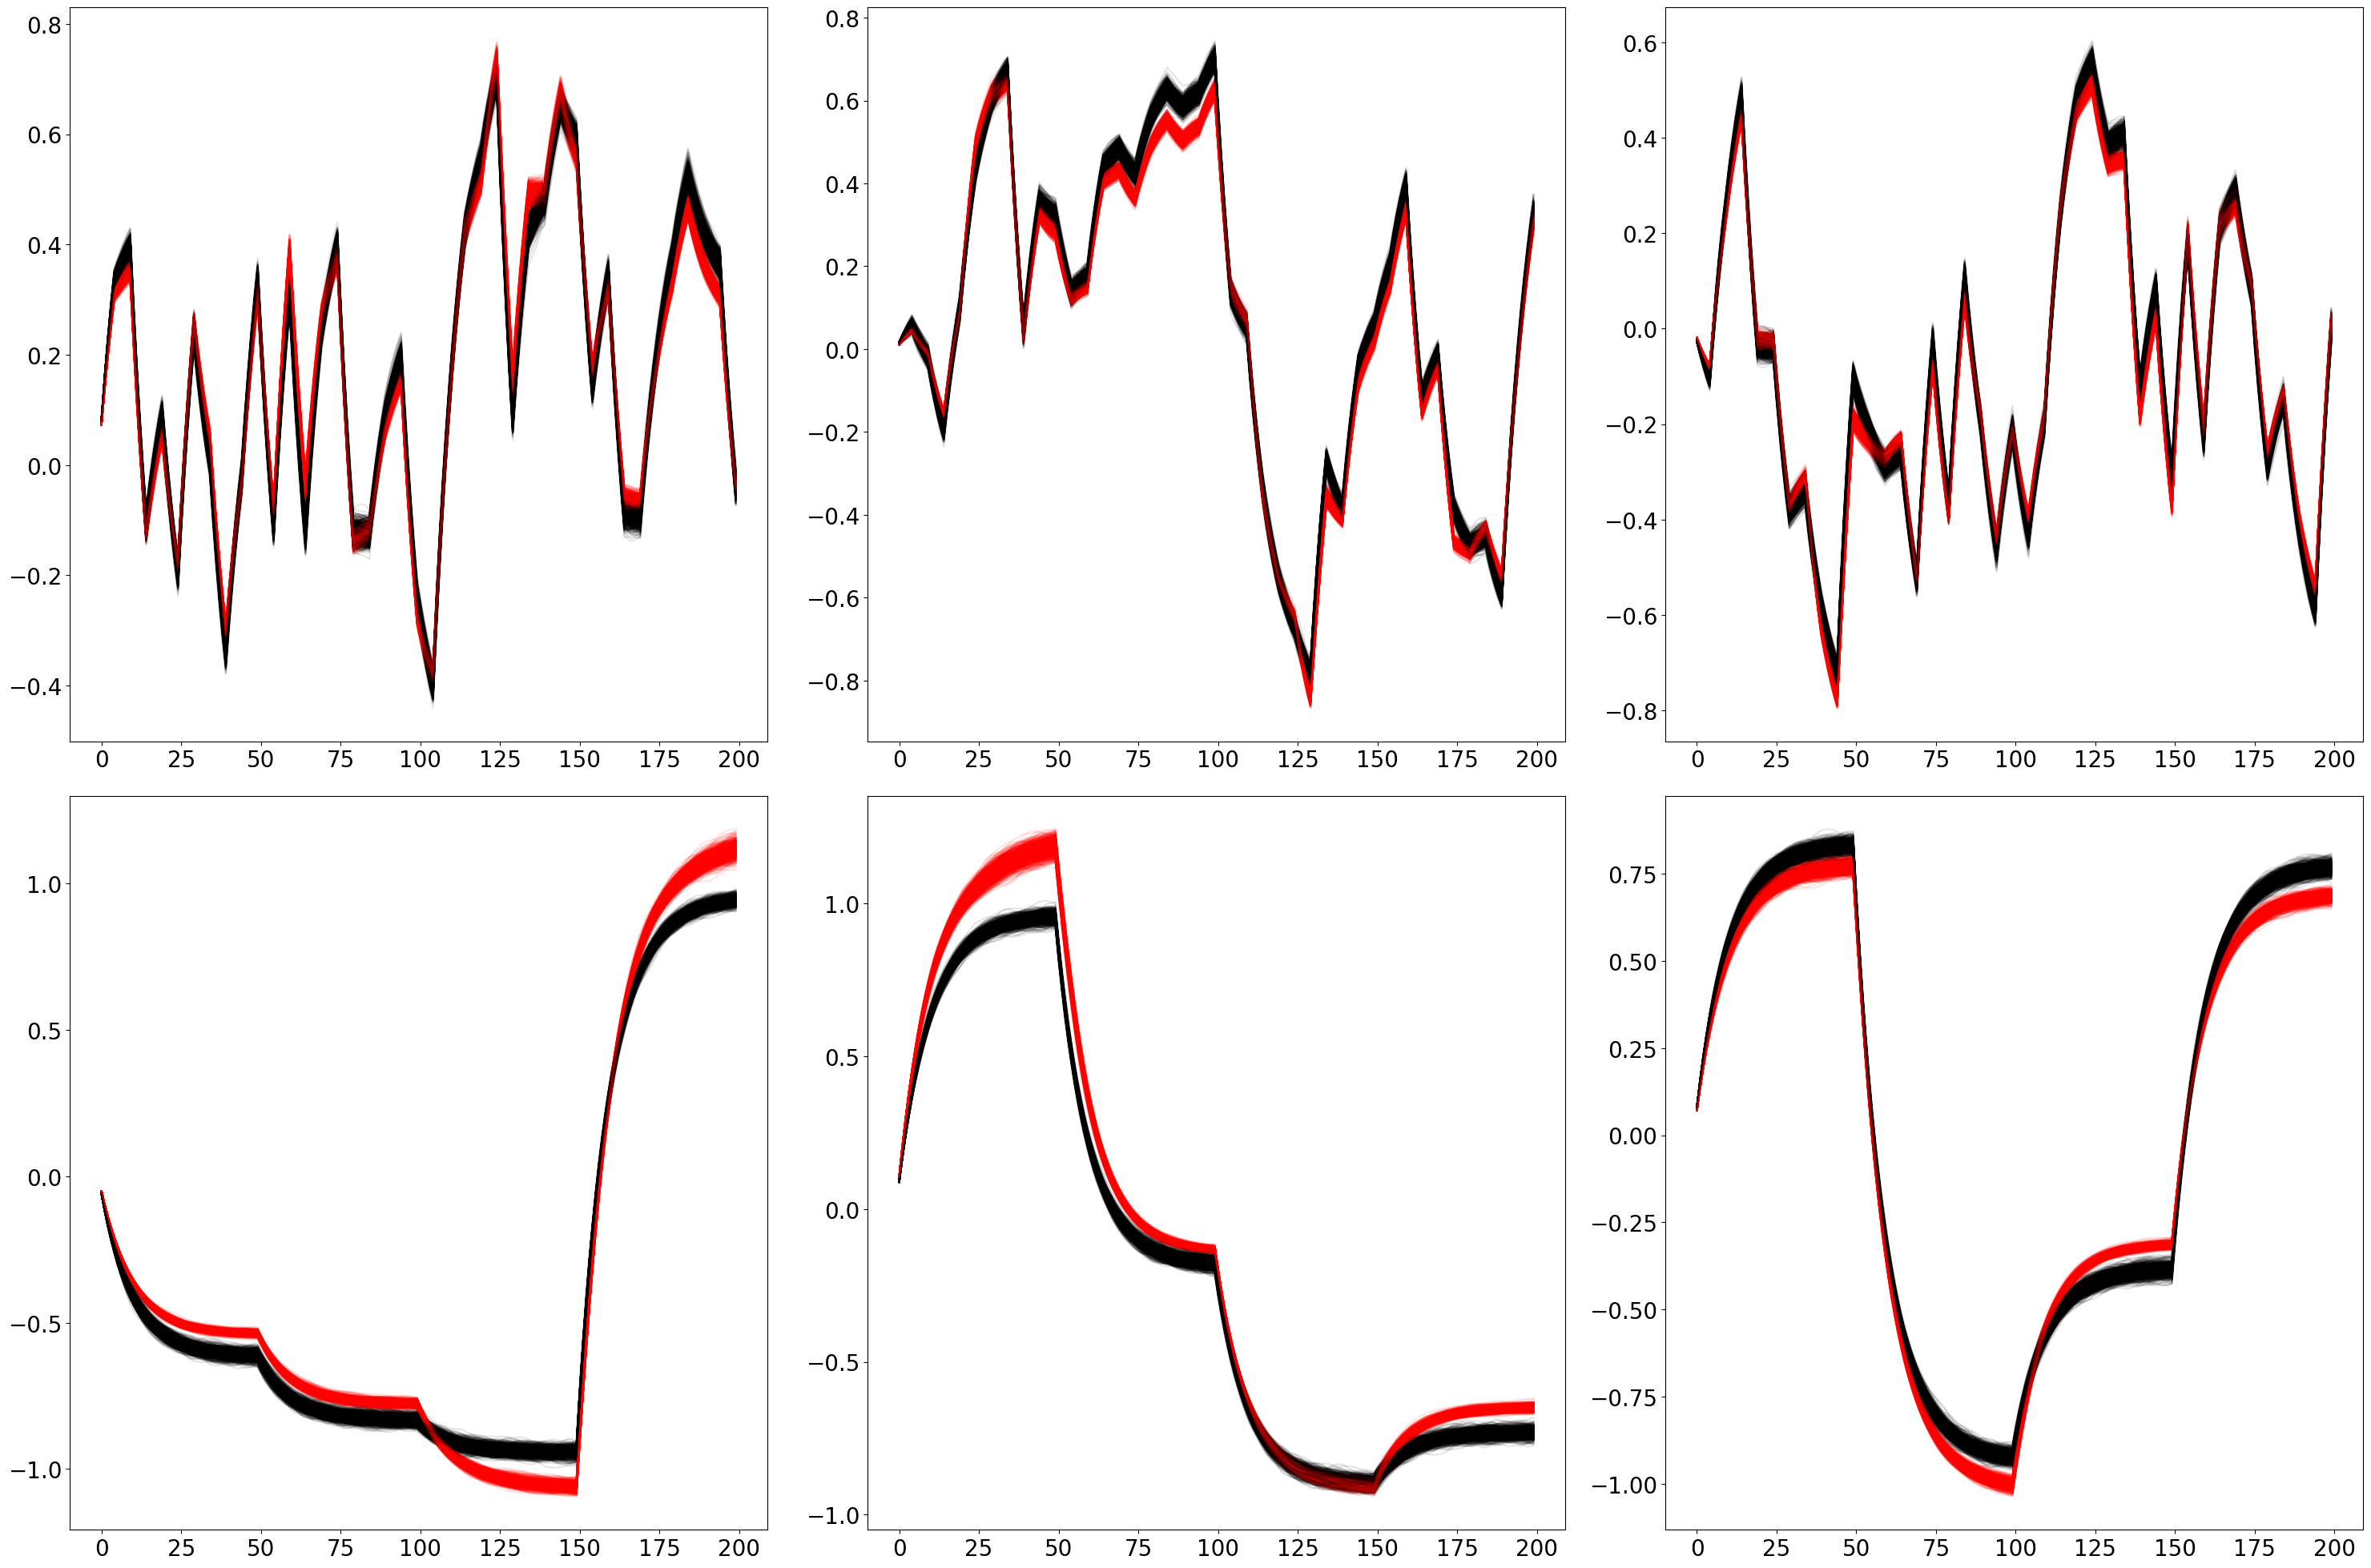

 75%|███████▌  | 1500/2000 [07:45<2:16:08, 16.34s/it]

1499  Errors on distributions Data: tensor([0.0434, 0.0042, 0.0003]) tensor([0.0433, 0.0044, 0.0004])


100%|█████████▉| 1999/2000 [09:31<00:00,  4.94it/s]  

New Plot, Old error:  tensor(0.0479) New Error:  tensor(0.0474)


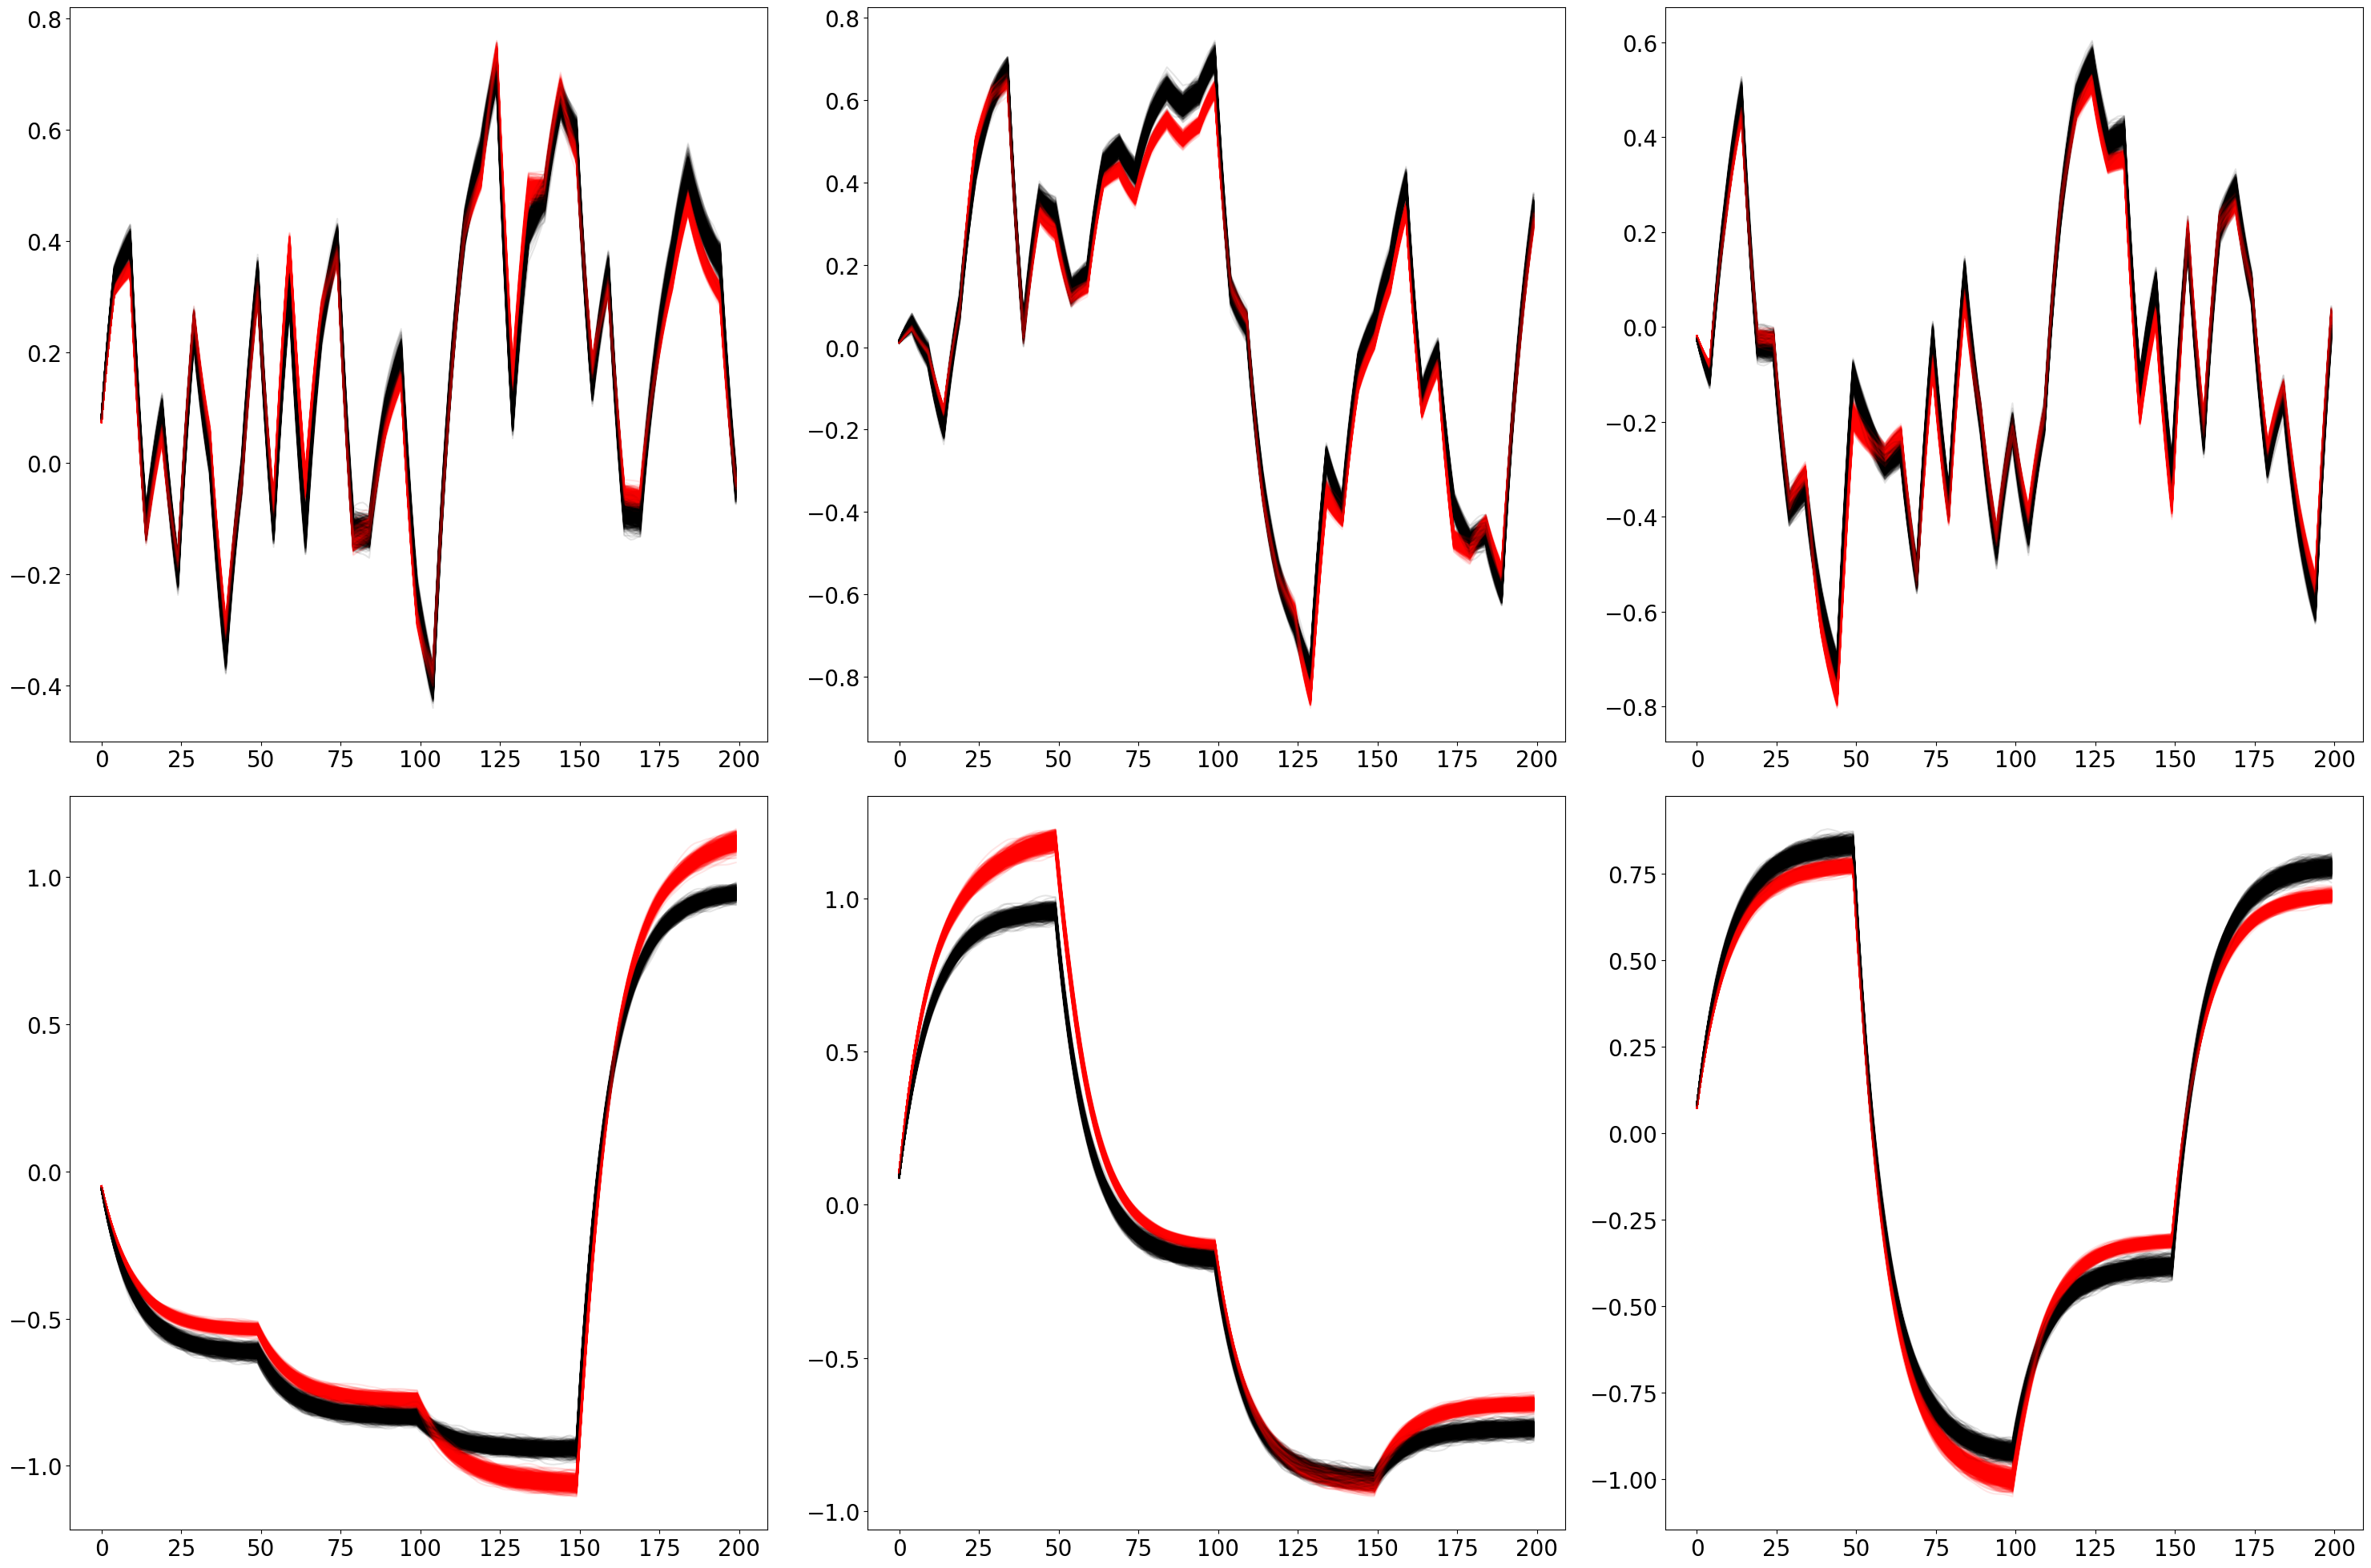

100%|██████████| 2000/2000 [10:24<00:00,  3.20it/s]

1999  Errors on distributions Data: tensor([0.0434, 0.0038, 0.0002]) tensor([0.0433, 0.0038, 0.0003])


In [15]:
from neural_SDE_training import train_NSDE_phase2
train_NSDE_phase2(N_SDE, N_ST, D_step, Input, Target, Input_val, Target_val, Input_te, Target_te, T_horizon, params, device,
                       batch_size, t0, etas, Train_F2, Errors_val1, Best_err_av, print_steps=500)

In [ ]:
print(Input[0].shape)
In = torch.zeros((1,2,250)).to(device)
X_generated=N_SDE.SDE_Seqforward(In, 0.0)

In [ ]:
print(X_generated.shape)
plt.plot(X_generated[0,0].cpu())
plt.show()